# Convolutional Neural Network

In this notebook the ConvNet is trained on full Ondřejov dataset
and then labels for LAMOST DR1 spectra are predicted.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import h5py
import spectraldl.preprocessing as preprocessing
import tensorflow.contrib.keras as keras
import numpy as np
import sklearn.metrics
import spectraldl.lamost as lamost
import spectraldl.plot as plot
import astropy.io.fits as fits
import random

In [3]:
with h5py.File('data/data.hdf5') as f:
    X = f['X'][...]
    y = f['y'][...]

## Preprocessing

In [4]:
X = preprocessing.scale_samples(X)
X, y = preprocessing.smote_over_sample(X, y, n_classes=3)
y_oh = keras.utils.to_categorical(y, num_classes=3)

/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')
/usr/local/lib/python3.5/dist-packages/imblearn/base.py:306: UserWarning: The target type should be binary.
  warnings.warn('The target type should be binary.')


## Training

In [5]:
HEIGHT = 1
WIDTH = 140
DEPTH = 1

In [6]:
X = X.reshape(-1, HEIGHT, WIDTH, DEPTH)

input_shape = X.shape[1:]
model = keras.models.Sequential([
    keras.layers.Conv2D(64, (1, 3), activation='relu', input_shape=input_shape),
    keras.layers.Conv2D(64, (1, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(1, 2)),
    keras.layers.Conv2D(128, (1, 3), activation='relu'),
    keras.layers.Conv2D(128, (1, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(1, 2)),
    keras.layers.Conv2D(256, (1, 3), activation='relu'),
    keras.layers.Conv2D(256, (1, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(1, 2)),
    keras.layers.Flatten(), 
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Keras model is saved in `data/convnet.hdf5` file.

In [7]:
# %%time
# callback = keras.callbacks.EarlyStopping(
#     monitor='loss',
#     min_delta=10e-5,
#     patience=50,
#     verbose=2
# )
# hist = model.fit(
#     X, y_oh,
#     epochs=1000, batch_size=256, verbose=2,
#     callbacks=[callback]
# )
# plt.plot(hist.epoch, hist.history['loss'])

# model.save('data/convnet.hdf5')
model = keras.models.load_model('data/convnet.hdf5')

In [8]:
y_pred = model.predict_classes(X)
idx = y_pred != y
np.count_nonzero(idx)

18309/18309 [==============================] - 3s     


20

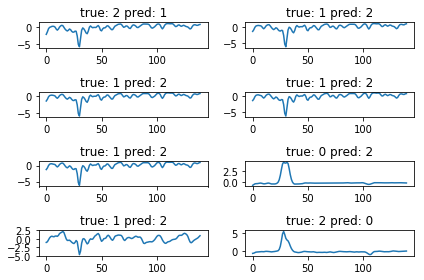

In [9]:
fig, axs = plt.subplots(4, 2)
for true, pred, x, ax in zip(y[idx], y_pred[idx], X[idx], axs.ravel()):
    ax.set_title('true: ' + str(true) + ' pred: ' + str(pred))
    ax.plot(x.reshape(-1))
fig.tight_layout()

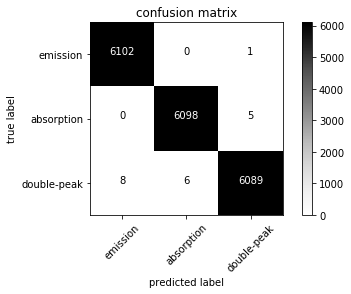

In [10]:
cm = sklearn.metrics.confusion_matrix(y, y_pred)
plot.plot_confusion_matrix(cm, ['emission', 'absorption', 'double-peak'])

## LAMOST Classification

In [11]:
%%time
with h5py.File('data/data.hdf5') as f:
    X_lam = f['X_lam']
    id_lam = f['id_lam']
    
    size = X_lam.shape[0]
    labels = np.zeros((size, ), dtype=np.int8)
    batch = 256
    for start in range(0, size, batch):
        end = start + batch if start + batch <= size else size        
        X_tmp = preprocessing.scale_samples(X_lam[start:end])
        X_tmp = X_tmp.reshape(-1, HEIGHT, WIDTH, DEPTH)
        labels[start:end] = model.predict_classes(X_tmp, batch_size=X_tmp.shape[0], verbose=0)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


CPU times: user 1min 5s, sys: 7.48 s, total: 1min 12s
Wall time: 1min 28s


In [12]:
np.count_nonzero(labels == 0), np.count_nonzero(labels == 1), np.count_nonzero(labels == 2)

(158115, 1898095, 145790)